## R SWAT - AutoML

In [3]:
library('swat')
library('dplyr')
library('readr')
library('stringr')

SWAT 1.5.0


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
conn <- CAS('pdcesx14159.exnet.sas.com', port=8777, 
            caslib = 'casuser', username = 'sasdemo',
            password = 'Orion123', protocol = "http")


NOTE: Connecting to CAS and generating CAS action functions for loaded

      action sets...

NOTE: To generate the functions with signatures (for tab completion), set 

      options(cas.gen.function.sig=TRUE).



In [5]:
data <- read.csv('./data/hmeq.csv', stringsAsFactors = FALSE)

In [6]:
ctbl <- as.casTable(conn,
                    data, 
                    casOut = list(name="hmeq", 
                               replace=FALSE,
                               promote = TRUE))

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(sasdemo).



In [7]:
tail(ctbl, n = 5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5956,0,87000,48980,89764,DebtCon,Other,14,0,0,209.0431,0,16,36.08804
5957,0,87500,55938,86794,DebtCon,Other,15,0,0,223.8810,0,16,36.75365
5958,0,88300,54004,94838,DebtCon,Other,16,0,0,193.7021,0,15,36.26269
5959,0,88500,50240,94687,DebtCon,Other,16,0,0,214.4262,0,16,34.75116
5960,0,88800,53307,94058,DebtCon,Other,16,0,0,218.3050,0,15,34.24246


In [30]:
actionsets <- c('dataSciencePilot', 'explainModel', 'aStore')
for(i in actionsets){
  loadActionSet(conn, i)
}

NOTE: Added action set 'dataSciencePilot'.

NOTE: Information for action set 'dataSciencePilot':

NOTE:    dataSciencePilot

NOTE:       exploreData - Exploration, automatic variable analysis and grouping using comprehensive statistical profiling of the variables.

NOTE:       screenVariables - Screens noise variables and variables that need special transformations to be useful in the downstream analytics.

NOTE:       analyzeMissingPatterns - Missing pattern analysis

NOTE:       exploreCorrelation - Explore linear and nonlinear correlation among the variables.

NOTE:       detectInteractions - Variable interaction detection and ranking

NOTE:       generateShadowFeatures - Generate shadow features.

NOTE:       featureMachine - Automated feature transformation and generation engine

NOTE:       selectFeatures - Feature selection

NOTE:       dsAutoMl - Automated machine learning pipeline exploration, execution and ranking.

NOTE: Added action set 'explainModel'.

NOTE: Information fo

In [39]:
colinfo <- head(cas.table.columnInfo(conn, table = 'hmeq')$ColumnInfo, -1)

In [40]:
# Variavel target
target <- colinfo$Column[1]
inputs <- colinfo$Column[-1]
nominals <- c(target, subset(colinfo, Type == 'varchar')$Column)

In [50]:
aml <- cas.dataSciencePilot.dsAutoMl(
  conn,
  table = list(name ='hmeq'),
  target = "BAD",
  explorationPolicy  = list(nominal = list(nominals = nominals)),
  event = '1',
  transformationPolicy  = list(missing = FALSE, cardinality = TRUE,
                               entropy = TRUE, iqv = TRUE,
                               skewness = TRUE, kurtosis = TRUE, 
                               Outlier = TRUE),
  modelTypes  = list("DECISIONTREE", "FOREST", "GLM", "GRADBOOST", "LOGISTIC", "NEURALNET"),
  objective = "AUC",
  sampleSize  = 20,
  topKPipelines = 20,
  kFolds  = 5,
  transformationOut = list(name= "TRANSFORMATION_OUT", replace = TRUE),
  featureOut  = list(name= "FEATURE_OUT", replace = TRUE),
  pipelineOut = list(name= "PIPELINE_OUT", replace = TRUE),
  saveState = list(name= "ASTORE_OUT", replace = TRUE)  
)

NOTE: Added action set 'autotune'.





NOTE: Added action set 'regression'.

NOTE: The SLSTAY option is not available for group LASSO selection and is ignored.

NOTE: The SLENTRY option is not available for group LASSO selection and is ignored.

NOTE: 566504 bytes were written to the table "_autotune_default_model_" in the caslib "CASUSER(sasdemo)".


NOTE: Added action set 'decisionTree'.






NOTE: Early stopping is activated; 'NTREE' will not be tuned.





NOTE: Added action set 'neuralNet'.

NOTE: Added action set 'autotune'.





NOTE: Added action set 'regression'.




NOTE: Convergence criterion (FCONV=1E-7) satisfied.

NOTE: There is possibly a quasi-complete separation of data points. The maximum likelihood estimate may not exist.

NOTE: 470251 bytes were written to the table "_autotune_default_model_" in the caslib "CASUSER(sasdemo)".


NOTE: Added action set 'decisionTree'.






NOTE: Early stopping is activated; 'NTREE' will not be tuned.





NOTE: Added action set 'ne

In [102]:
best_models <- aml$keyedList[names(aml$keyedList) %>% str_subset('BestConfi')]
best_models

,Parameter,Name,Value
,<chr>,<chr>,<chr>
1,Evaluation,Evaluation,5
2,Model Selection Method,METHOD,STEPWISE
3,Significance Level for Entry,SLENTRY,0.05
4,Significance Level for Removal,SLSTAY,0.05
5,Stop Horizon,STOPHORIZON,3
6,Lasso Regularization,LASSORHO,0.75
7,Maximum Lasso Steps,LASSOSTEPS,5
8,Area Under Curve,Objective,0.8410597442
,Parameter,Name,Value


In [109]:
best_names <- objects(best_models)
best_rocs <- str_replace(best_names,pattern = 'BestConfiguration', replacement = 'ROCInfo')

In [122]:
roc.df <- data.frame()

for (i in 1:length(best_rocs)){
    tmp <- get(best_rocs[i], aml$keyedList)
    tmp$Model <- best_names[i]
    roc.df <- rbind(roc.df, tmp)
}

In [123]:
head(roc.df)

,Variable,Event,CutOff,TP,FP,FN,TN,Sensitivity,Specificity,KS,...,FPR,ACC,FDR,F1,C,Gini,Gamma,Tau,MISCEVENT,Model
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,P_BAD1,1,0.00,1189,4771,0,0,1.0000000,0.000000000,0,...,1.0000000,0.1994966,0.8005034,0.3326339,0.8343984,0.6687967,0.6786803,0.2136465,0.8005034,BestConfiguration_1_Logistic
2,P_BAD1,1,0.01,1185,4744,4,27,0.9966358,0.005659191,0,...,0.9943408,0.2033557,0.8001349,0.3329587,0.8343984,0.6687967,0.6786803,0.2136465,0.7966443,BestConfiguration_1_Logistic
3,P_BAD1,1,0.02,1185,4631,4,140,0.9966358,0.029343953,0,...,0.9706560,0.2223154,0.7962517,0.3383298,0.8343984,0.6687967,0.6786803,0.2136465,0.7776846,BestConfiguration_1_Logistic
4,P_BAD1,1,0.03,1182,4400,7,371,0.9941127,0.077761476,0,...,0.9222385,0.2605705,0.7882479,0.3491360,0.8343984,0.6687967,0.6786803,0.2136465,0.7394295,BestConfiguration_1_Logistic
5,P_BAD1,1,0.04,1174,4025,15,746,0.9873844,0.156361350,0,...,0.8436387,0.3221477,0.7741873,0.3675642,0.8343984,0.6687967,0.6786803,0.2136465,0.6778523,BestConfiguration_1_Logistic
6,P_BAD1,1,0.05,1160,3662,29,1109,0.9756098,0.232446028,0,...,0.7675540,0.3807047,0.7594359,0.3859591,0.8343984,0.6687967,0.6786803,0.2136465,0.6192953,BestConfiguration_1_Logistic


In [100]:
library('ggplot2')

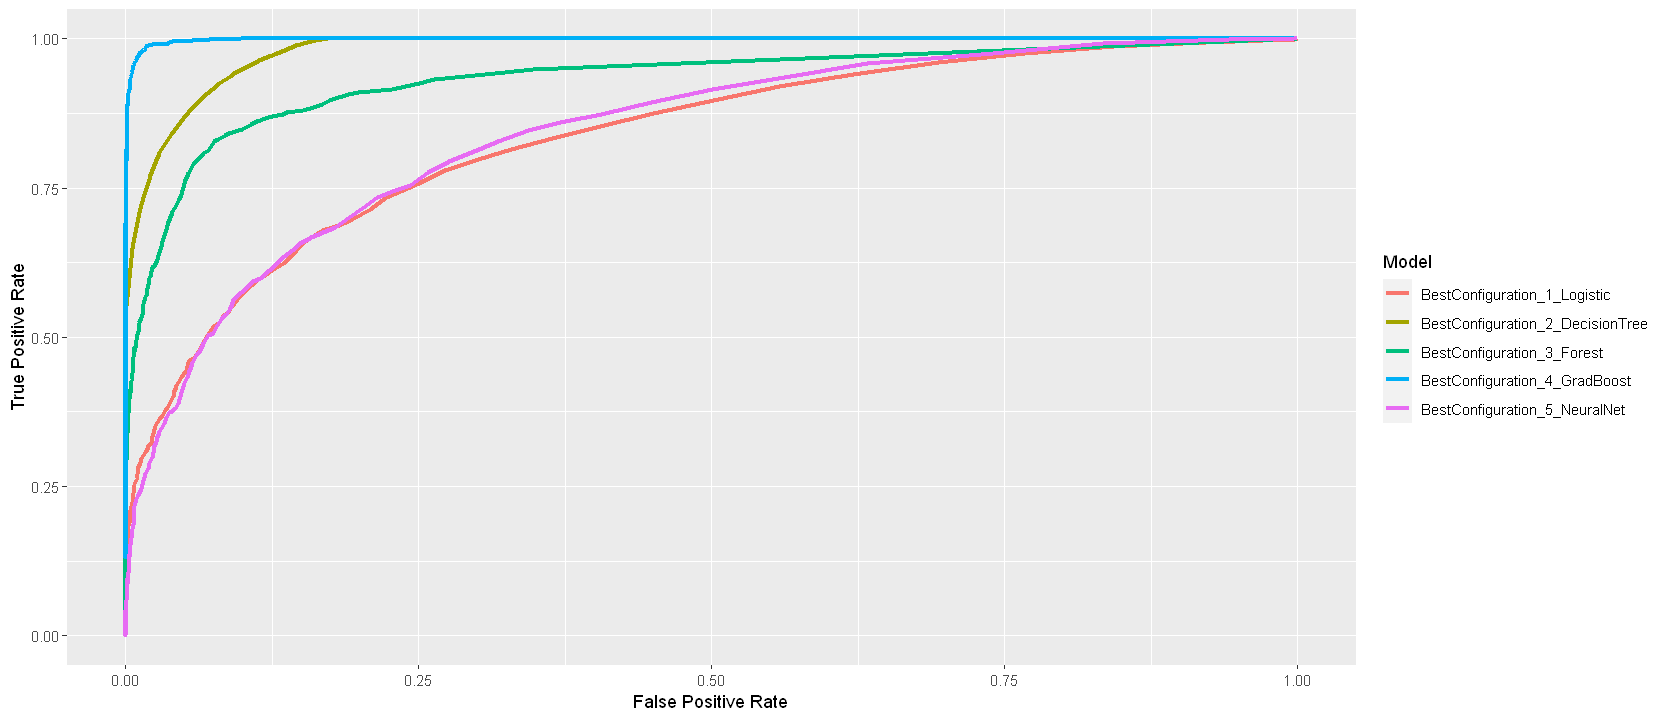

In [124]:
# Cria curva ROC
options(repr.plot.width=14, repr.plot.height=6)

ggplot(data = roc.df[c('FPR', 'Sensitivity', 'Model')],
    aes(x = as.numeric(FPR), y = as.numeric(Sensitivity), colour = Model)) +
    geom_line(size =1.2) +
    labs(x = 'False Positive Rate', y = 'True Positive Rate')

In [80]:
df_scored <- cas.astore.score(
        conn, 
        out = list(name = "hmeq_scored", replace = TRUE), 
        rstore = "ASTORE_OUT", 
        table = "hmeq"
       )


In [81]:
df_scored$OutputCasTables

,casLib,Name,Rows,Columns
,<chr>,<chr>,<dbl>,<dbl>
1,CASUSER(sasdemo),hmeq_scored,5960,27


In [82]:
df_scored

$OutputCasTables
            casLib        Name Rows Columns
1 CASUSER(sasdemo) hmeq_scored 5960      27

$Timing
                Task      Seconds     Percent
1  Loading the Store 0.0001261234 0.006881032
2 Creating the State 0.0072860718 0.397512943
3            Scoring 0.0101320744 0.552784932
4              Total 0.0183291435 1.000000000

In [88]:
## best features
scored <- defCasTable(conn, 'hmeq_scored')
head(scored)

,nhoks_nloks_dtree_10_CLAGE,nhoks_nloks_dtree_5_CLAGE,nhoks_nloks_pow_n0_5_CLAGE,nhoks_nloks_pow_n1_CLAGE,hk_dtree_disct10_DEBTINC,hk_dtree_disct5_DEBTINC,hk_yj_0_DEBTINC,hk_yj_p1_DEBTINC,ho_dtree_disct10_MORTDUE,ho_dtree_disct5_MORTDUE,...,nhoks_nloks_pow_n2_YOJ,lcnhenhi_dtree5_DELINQ,lcnhenhi_woe5_DELINQ,lcnhenhi_dtree5_DEROG,lcnhenhi_woe5_DEROG,hc_tar_evt_prob_LOAN,hc_tar_frq_rat_LOAN,lcnhenhi_dtree5_NINQ,lcnhenhi_woe5_NINQ,lchehi_lab_JOB
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,2,0.10240041,0.010485844,0,0,3.578458,34.81826,2,1,...,0.007561437,1,5,1,5,0.2115159,0.5,2,4,3
2,4,2,0.09022811,0.008141113,0,0,3.578458,34.81826,5,2,...,0.015625000,3,4,1,5,0.2115159,0.5,1,5,3
3,4,2,0.08152294,0.006645990,0,0,3.578458,34.81826,1,1,...,0.040000000,1,5,1,5,0.2115159,0.5,2,4,3
4,0,0,0.07570835,0.005731754,0,0,3.578458,34.81826,0,0,...,0.015625000,0,0,0,0,0.2115159,0.5,0,0,0
5,2,2,0.10295973,0.010600707,0,0,3.578458,34.81826,8,3,...,0.062500000,1,5,1,5,0.2115159,0.5,1,5,2
6,3,2,0.09878934,0.009759335,8,4,3.640572,37.11361,2,1,...,0.010000000,1,5,1,5,0.2115159,0.5,2,4,3


In [ ]:

cas.terminate(conn)